# Predict early readmission for diabetes patients based on their laboratory and medications record 

In this lab, we are going to use a dataset of diabetes patients and to build an unbiased models to predict whether they will be readmitted within 30 days since the current encounter based on laboratory test performed and medications taken during their stay. 

**There are two parts of this lab and in the first one we will cover the following key points:**

* Reproduce a dataset based on a paper
> The dataset we use is provided by the Health Facts, while it is extracted and analyzed in the following research work: Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, John N. Clore, "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records", *BioMed Research International*, vol. 2014, Article ID 781670, 11 pages, 2014. https://doi.org/10.1155/2014/781670
>	
We will perform data verification based on the paper’s description and conduct data preparation by mostly following the steps used  in their work while performing modifications as indicated in each section for the sake of this exercise. 

* Use scikit-learn to conduct feature engineering and model training
> We train a classifier to predict early readmission based on encounter records except specific sensitive features. There are both numerical and categorical features in the dataset and we will apply appropriate feature transformation techniques before fitting into the model. Here we will also focus on how to use sklearn.pipeline.Pipeline to assemble the operations. 

* Evaluate models’ performance with different metrics
> Once we obtain the model,  we will explore a series of performance metrics  and observes how they serve differently when it comes to model evaluation for our problem, especially given its extremely unbalanced rate between positive and negative outcomes.  

**The second part we will focus on [Fairlearn](https://fairlearn.github.io), which  is a Python toolkit to assist in assessing and mitigating unfairness in machine learning models. Contents prepared include:**
 
* Assess model's sensitivity in terms of various fairness and accuracy metrics
>Sensitive features relevant to our task include patients’ race, gender and age. We will use modules provided in Fairlearn to assess model's sensitivity when it comes to any individual of these features, or under the intersection of them. We will also quantify disparities among subgroups with different methods provided. Furthermore, we will introduce the concept about control features and how you can conduct relevant analysis with Fairlearn.  

* Mitigate unfairness observed in the model
>There are three groups of mitigation methods provided in Fairlearn: preprocessing, reduction and postprocessing. We select two specific algorithms to mitigate the observed unfairness in the model obtained from the first part. 

We would like to thank Roman Lutz, who is one of the main contributors to Fairlearn, sincerely for  
his precise suggestions and assistance in the preparation of this material.      




## Step 0: Setups  

In [ ]:
!pip install --upgrade raiwidgets==0.2.0
!pip install --upgrade fairlearn==v0.6.0
!pip install -U scikit-learn==0.24.1

     |████████████████████████████████| 3.9MB 5.0MB/s 
     |████████████████████████████████| 1.8MB 32.1MB/s 
     |████████████████████████████████| 133kB 40.7MB/s 
     |████████████████████████████████| 788kB 36.5MB/s 
     |████████████████████████████████| 5.4MB 36.4MB/s 
     |████████████████████████████████| 368kB 41.7MB/s 
     |████████████████████████████████| 245kB 44.2MB/s 
     |████████████████████████████████| 163kB 32.9MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.16 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling p

     |████████████████████████████████| 24.6MB 2.0MB/s 
     |████████████████████████████████| 22.3MB 1.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Step 1: Data loading
The original data files can be download as supplementary of the paper at https://www.hindawi.com/journals/bmri/2014/781670/#supplementary-materials. 

Here we provide a link to the shared csv file which you can use to read into your own working space on colaboratory.   

Link: https://drive.google.com/file/d/13zSR_W20MWknPr2cbXS6Ck-GmLufpNPT/view?usp=sharing 

Let's use PyDrive to load the data.

In [ ]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client. 
# Please follow the steps as instructed when you run the following commands. 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Load the same with information provided above in the link. 
fileid = '13zSR_W20MWknPr2cbXS6Ck-GmLufpNPT'   
filename = 'diabetic_data_initial.csv'
downloaded = drive.CreateFile({'id':fileid}) 
downloaded.GetContentFile(filename)  
data = pd.read_csv(filename)

In [ ]:
# Check the data loaded.
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
# Map id to actual meaning of admission type and create a column named 'admission_type' in the data frame.
names = ['Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available', 'NULL', 'Trauma Center', 'Not Mapped']

data['admission_type'] = [names[i-1] for i in data.admission_type_id]


## Step 2: Data exploration

In the paper, Strack et al extracted and selected the above data from the Health Facts database based on the following criteria:    

1. It is an inpatient encounter (a hospital admission).
2. It is a “diabetic” encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
3. The length of stay was at least 1 day and at most 14 days.
4. Laboratory tests were performed during the encounter.
5. Medications were administered during the encounter.

In the data that we'll use in the following analysis, there are 101,766 encounters identified and 55 features selected by clinical experts. Features include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information. More details about each feature can be found in Table 1 in the paper.

Let's verify the above statements with the data loaded by checking basic stats of it! 

In [ ]:
# Get a summary of the dataset with pandas.  
data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


Confirm rule 3 ("The length of stay was at least 1 day and at most 14 days") by checking the distribution of column named time_in_hospital, which measures the integer number of days between admission and discharge:

In [ ]:
# write your code here
rule3 = data['time_in_hospital']
rule3.describe()


count    101766.000000
mean          4.395987
std           2.985108
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          14.000000
Name: time_in_hospital, dtype: float64

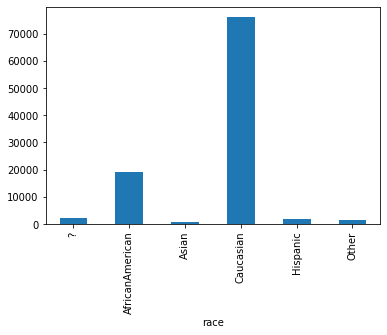

In [ ]:
data.groupby(['race'])['patient_nbr'].count().plot.bar()

In [ ]:
# let's drop records with missing values for gender 
print(data.gender.unique())
data = data.loc[data['gender']!='Unknown/Invalid']

['Female' 'Male' 'Unknown/Invalid']


## Step 3: Data formulation

There were several features that could not be treated directly since they had a high percentage of missing values. These features were 
  weight (97% values missing), 
  payer code (40%), 
  and medical specialty (47%). 

In [ ]:
## Features to drop
# 'Weight attribute was considered to be too sparse and it was not included in further analysis.'
data = data.drop(columns='weight')
# 'Payer code was removed since it had a high percentage of missing values and it was not considered relevant to the outcome.'
data = data.drop(columns='payer_code')
# 'Medical specialty attribute was maintained, adding the value “missing” in order to account for missing values.'
# For simplicity, we drop this column instead. 
data = data.drop(columns='medical_specialty')

 The preliminary dataset contained multiple inpatient visits for some patients 
  and the observations could not be considered as statistically independent, 
  an assumption of the logistic regression model.

  Authors of the paper performed a specific filtering criteria but here for simplicity, 
  we drop all records from patients who have more than one encounter.

  After performing the above operation, 
   we were left with 54,745 encounters that constituted the final dataset for analysis.

(array([6.9925e+04, 1.3810e+03, 1.5100e+02, 3.2000e+01, 1.8000e+01,
        6.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1. ,  4.9,  8.8, 12.7, 16.6, 20.5, 24.4, 28.3, 32.2, 36.1, 40. ]),
 <a list of 10 Patch objects>)

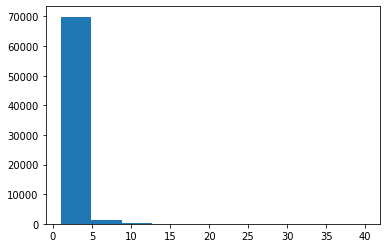

In [ ]:
#check the number of encounters per patient
plt.hist(data.groupby(['patient_nbr'])['encounter_id'].nunique())

In [ ]:
# dropping records 
encounter_counts = data.groupby(['patient_nbr'])['encounter_id'].nunique()
data = data[data.patient_nbr.isin(encounter_counts[encounter_counts.values == 1].index)]

(array([    0.,     0.,     0.,     0.,     0., 54742.,     0.,     0.,
            0.,     0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

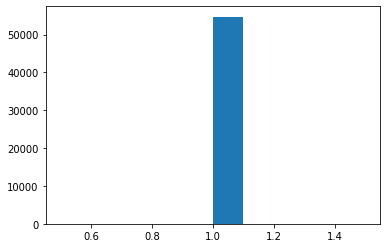

In [ ]:
# check the distribution again.
plt.hist(data.groupby(['patient_nbr'])['encounter_id'].nunique())

Final definition and preparation for 
* target variable
* sensitive features
* features as model inputs



In [ ]:
'''
Target variable, readmitted, is binarized as below: 
  =1:  “readmitted” if the patient was readmitted within 30 days of discharge or 
  =0:   “otherwise” which covers both readmission after 30 days and no readmission at all. 
''' 
Y = (data['readmitted']=='<30').astype('int')
print(f'Readmitted rate within 30 days of discharge in the dataset={sum(Y==1)/len(Y)*100:1.3f}%')

Readmitted rate within 30 days of discharge in the dataset=3.957%


In [ ]:
#Sensitive and control variables including demographics, severity and type of the disease, and type of admission.
sensitive_control_features = ['race', 'gender', 'age', 
          'admission_type', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
          ]
A = data[sensitive_control_features]
X_raw = data.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'] + sensitive_control_features)

In [ ]:
from sklearn.model_selection import train_test_split

#Denoting categorical variables 
for col in ['max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
          'num_medications', 'number_outpatient', 'number_emergency',
          'number_inpatient', 'number_diagnoses',
          'diag_1', 'diag_2', 'diag_3',
       ]:

    X_raw[col] = X_raw[col].astype('category')

(X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, Y, A, test_size=0.5, random_state=10000, stratify=Y
)

# Ensure indices are aligned between X, y and A,
# after all the slicing and splitting of DataFrames
# and Series

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

## Step 4: Train a classifier to predict early readmission based on encounter records and evaluate its performance.

### Use **sklearn.pipeline.Pipeline** to perform feature engineering and to train a classifier.

**scikit-learn** or **sklearn** is a python module consisting of simple and efficient tools for predictive data analysis (preprocessing, feature selection, dimensionality reduction, regression, classification, clustering, et cetera).

**sklearn.pipeline.Pipeline** object takes a list of **transforms** and a final **estimator** and applies them sequentially on data.
- The possible transforms are preprocessing (e.g., MinMaxScaler, OneHotEncoder), missing value imputation (e.g., KNNImputer, SimpleImputer), dimensionality reduction (e.g., PCA), label encoding (e.g., LabelBinarizer), etc. Any transformers in the pipeline must implement fit and transform methods. For a more complete list, see: https://scikit-learn.org/stable/data_transforms.html

- The final part of the pipeline, the estimator, needs to implement a fit function at the least. The estimators can be classifiers, regressors, etc. For a more complete list, see: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

The purpose of setting up a pipeline is to allow the different transforms and estimator to be cross-validated together when setting their parameters. It also allows for the application of a pre-configured pipeline on new raw data. The different steps of the pipeline and their parameters can be accessed using their 'names'.

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

unmitigated_predictor = Pipeline(
    steps=[
           #feature engineering component 
        ("preprocessor", ColumnTransformer(transformers=[
                                              # we use selector to indentify features based on its data type
                                              # Normalize numerical features
                                               ("num", StandardScaler(), selector(dtype_exclude="category")), 
                                              # Encoding (transforming) categorical features to what understandable by the model
                                              ("cat", OneHotEncoder(handle_unknown="ignore"), selector(dtype_include="category")),
                                            ]
                                          )
        ),
        # model component
        ("classifier",
         LogisticRegression(penalty='l2', C=0.1, verbose=0, max_iter=1000, 
                            class_weight={0:1, 1:10}),
        ),
    ]
)

## Step 5: Calculate performance and fairness metrics

Given the context of our task, we consider the following metrics:
* Sample size
* Selection rate, percentage of positive cases:  fraction of predicted labels matching the ‘good’ outcome
* Accuracy: $\frac{TP + TN}{P + N}$
* FNR, percentage among readmitted that were predicted not to be readmitted (patients that could have used extra attention but did not get it): $\frac{FN}{FN + TP}$
* FPR, percentage among not readmitted that were predicted to be readmitted ("unnecessarily getting extra attention" - these people take resources that the hospital could have given to patients in need): $\frac{FP}{FP + TN}$
* Average Precision: Summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight
  * Precision: number of patients that were readmitted among those who were predicted to be readmitted: $\frac{TP}{TP + FP}$. High precision relates to a low FPR. 
  * Recall: number of patients that were readmitted among those needed to be readmitted $\frac{TP}{TP + FN}$. High recall relates to a low FNR. 
  * To learn more about precision and recall, visit 
  https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
* ROC AUC score: Computes Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores. 
  * ROC curve is defined by FPR (x values) and TPR (y values). The purpose of the graph is to illustrate the trade-offs between TP and FP. 
  * To learn more about ROC curve, visit https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

Let's assess the performance of the classifier:

In [ ]:
import sklearn.metrics as skm

unmitigated_predictor.fit(X_train, y_train)
y_pred = unmitigated_predictor.predict(X_test)

# get the overall performance metrics of the classifer
print("accuracy:", skm.accuracy_score(y_test, y_pred))
print("AUC:", skm.roc_auc_score(y_test, y_pred))
print('precision:', skm.precision_score(y_test, y_pred))
print('recall:', skm.recall_score(y_test, y_pred))
print('average_precision:', skm.average_precision_score(y_test, y_pred))

accuracy: 0.8979942274670272
AUC: 0.587898311845379
precision: 0.12072791833111407
recall: 0.25115420129270544
average_precision: 0.05995122416158056


What does each metric tell us about the performance of the classifier?

Are there other metrics you could calculate?
 

**Write your answer in this text cell:**
With a low average percision, it appears that the classifier is not the most precise and the accuracy at around 90% can be better. If the topic carried more weight, this accuracy would be low. Also with the AUC at 0.59, it is clear that the predictions are not helping who they most should. When it comes to health topics, scarcity in healthcare already exists and when the current existing resources are not being properly used, it makes a huge impact on who gets access to care or not.

I think these metrics are sufficient to give us a solid overlook of the performance of this classifier. If anything, I would calculate the raw False Positive Rate and False Negative Rates just to compare them. 

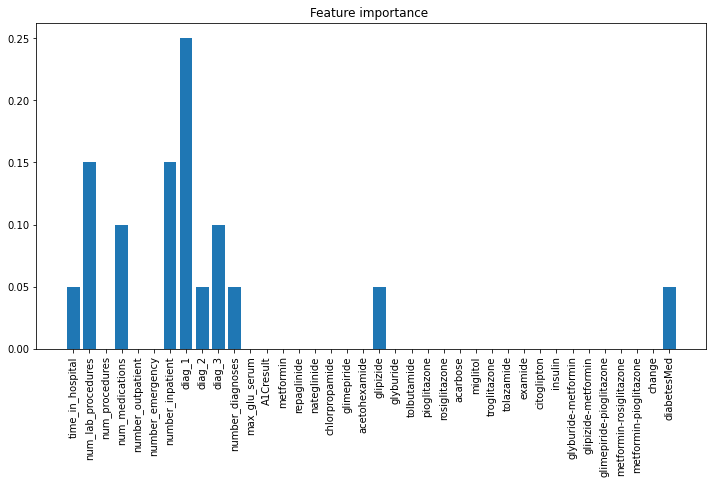

In [ ]:
# We can obtain feature importance if tree based models are adopted. 
# For example, we use AdaBoostClassifier and OrdinalEncoder for categorical features.

from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OrdinalEncoder

treebased_predictor = Pipeline(
    steps=[
           #feature engineering component 
        ("preprocessor", ColumnTransformer(transformers=[
                                              # we use selector to indentify features based on its data type
                                              # Normalize numerical features
                                               ("num", StandardScaler(), selector(dtype_exclude="category")), 
                                              # Encoding (transforming) categorical features to what understandable by the model
                                              ("cat", OrdinalEncoder(handle_unknown="ignore"), selector(dtype_include="category")),
                                            ]
                                          )
        ),
        # model component
        ("classifier",
         AdaBoostClassifier(n_estimators=20, learning_rate=1.0),
        ),
    ]
)

treebased_predictor.fit(X_train, y_train)
# y_pred = treebased_predictor.predict(X_test)

feature_importances = treebased_predictor.named_steps['classifier'].feature_importances_ 

plt.figure(figsize=(12, 6))
plt.bar(x=range(len(X_train.columns)), height=feature_importances)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=90)
plt.title("Feature importance ")
plt.show()

### Use **fairlearn.metrics.MetricFrame** class to inspect model's fairness

We know that there are sensitive features in our data, and we want to ensure that we’re not harming individuals due to membership in any of these groups. For this purpose, Fairlearn provides the fairlearn.metrics.MetricFrame class. 

The **fairlearn.metrics.MetricFrame** object requires a minimum of four arguments:

* The underlying metric function(s) to be evaluated
* The true values
* The predicted values
* The sensitive feature values

Metric functions must have a signature ''fn(y_true, y_pred)'', i.e., require only two arguments.



In [ ]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_negative_rate, false_positive_rate

import functools
import numpy as np

def insensitive_roc_auc(y_true, y_score):
    #to handle subgroups with only one class.
    if sum(y_true)!=len(y_true) and sum(y_true)!=0:
        return skm.roc_auc_score(y_true, y_score)
    else:
        return np.nan

def samplesize(y_true, y_score):
    return len(y_true)

#Metrics 
metric_fns = {'samplesize': samplesize, 
              'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their label
              'FNR': false_negative_rate, 
              'FPR': false_positive_rate, 
              'accuracy': skm.accuracy_score,
              'average_precision': skm.average_precision_score,
              'roc_auc_score': insensitive_roc_auc 
              }

grouped_on_race = MetricFrame(metric_fns,
                             y_test, y_pred,
                             sensitive_features=A_test['race'])

The **fairlearn.metrics.MetricFrame** has the **overall** property, 
which contains the metrics evaluated on the entire dataset. We see that this contains the same values calculated above:

In [ ]:
#We can inspect the overall values, and check they are as expected:
assert grouped_on_race.overall['selection_rate'] == selection_rate(y_test, y_pred)
assert grouped_on_race.overall['accuracy'] == skm.accuracy_score(y_test, y_pred)
print(grouped_on_race.overall)

samplesize               27371
selection_rate       0.0823134
FNR                   0.748846
FPR                  0.0753576
accuracy              0.897994
average_precision    0.0599512
roc_auc_score         0.587898
dtype: object


#### Performance breakdown by subgroups
The other property in the **fairlearn.metrics.MetricFrame** object is **by_group**. This contains the metrics evaluated on each subgroup defined by the categories in the sensitive_features (*race* in our case). 

In [ ]:
grouped_on_race.by_group

,samplesize,selection_rate,FNR,FPR,accuracy,average_precision,roc_auc_score
race,,,,,,,
?,858,0.0431235,0.826087,0.039521,0.939394,0.0409459,0.567196
AfricanAmerican,4845,0.0662539,0.714286,0.0600594,0.921981,0.0534307,0.612827
Asian,230,0.0521739,0.833333,0.0458716,0.913043,0.071256,0.560398
Caucasian,20368,0.0882757,0.751991,0.0810714,0.889974,0.0625229,0.583469
Hispanic,584,0.0958904,0.666667,0.0843806,0.888699,0.0843933,0.624476
Other,486,0.0596708,0.888889,0.0587002,0.925926,0.0202923,0.526205


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f945d2643d0>,
      dtype=object)

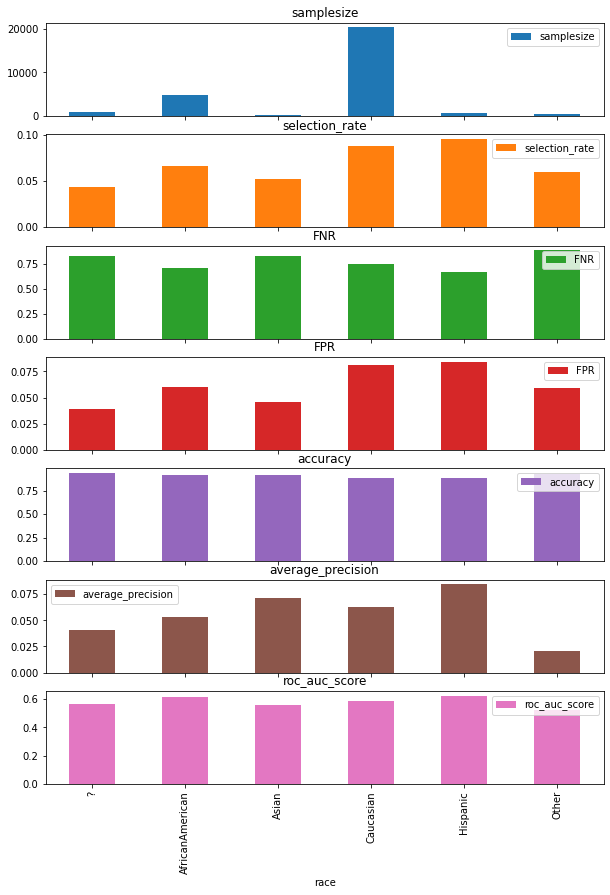

In [ ]:
# Plot the metric values
grouped_on_race.by_group.plot.bar(subplots=True, figsize=(10, 14))

Are there any differences in the performance metrics by race that stand out to you?

**Write your answer in this text cell:**

To be honest the only things that really stand out to me are the heavily varying sample sizes and the drastic dip in percision when it comes to the "other" category. The accuracy is relatively even among all the racial groups. The dip in precision for the "other" race I believe comes from the fact that race can predict underlying conditions that can affect one's health, so with a less-studied/ common race, healthcare providers might have difficulty deciding how a person's health will be.

#### Quantifying Disparities 
**Fairlearn** provides several means of aggregating metrics across the subgroups, so that disparities can be readily quantified.

In [ ]:
'''
The simplest of these aggregations is group_min(), which reports the minimum value 
seen for a subgroup for each underlying metric (as well as group_max()). 
This is useful if there is a mandate that “no subgroup should have an accuracy() of less than 0.8.” 
'''
grouped_on_race.group_min()

samplesize                 230
selection_rate       0.0431235
FNR                   0.666667
FPR                   0.039521
accuracy              0.888699
average_precision    0.0202923
roc_auc_score         0.526205
dtype: object

In [ ]:
'''
The difference between metrics achieved on subgroups can be quantified 
in terms of a difference between the subgroup with the highest value of the metric, and the subgroup with the lowest value.
'''
grouped_on_race.difference(method='between_groups')

samplesize           20138.000000
selection_rate           0.052767
FNR                      0.222222
FPR                      0.044860
accuracy                 0.050695
average_precision        0.064101
roc_auc_score            0.098271
dtype: float64

In [ ]:
'''
We can also evaluate the difference relative to the corresponding overall value of the metric. 
In this case we take the absolute value, so that the result is always positive:'
'''
grouped_on_race.difference(method='to_overall')

samplesize           27141.000000
selection_rate           0.039190
FNR                      0.140043
FPR                      0.035837
accuracy                 0.041400
average_precision        0.039659
roc_auc_score            0.061693
dtype: float64

#### Intersections of sensitive features
We can examine the intersections of sensitive features by passing multiple columns to the fairlearn.metrics.MetricFrame constructor:

In [ ]:
grouped_on_race_and_sex = MetricFrame(metric_fns,
                                      y_test, y_pred,
                                      sensitive_features=A_test[['race', 'gender']])

In [ ]:
grouped_on_race_and_sex.by_group

samplesize  ... roc_auc_score
race            gender             ...              
?               Female        436  ...      0.517185
                Male          422  ...      0.631796
AfricanAmerican Female       2919  ...      0.624769
                Male         1926  ...      0.593851
Asian           Female        116  ...      0.473214
                Male          114  ...      0.606132
Caucasian       Female      10332  ...      0.584707
                Male        10036  ...      0.582114
Hispanic        Female        316  ...        0.6475
                Male          268  ...      0.591617
Other           Female        243  ...      0.470464
                Male          243  ...        0.6375

[12 rows x 7 columns]

Look over the metrics by race and sex. Are there any metrics that have notable intersectional disparities?


**Write your answer in this text cell:**

In false negative rates, it appears that females in the unknown, Asian, and other categories have much higher (sometimes even 100%) false negative rates compared to their male counterparts. This means that women in these race categories are more likely to be deemed as healthier/ non-diabetic, but then readmitted later.

#### Control Features
There is a further way we can slice up our data. We have features for the patients' *admission_type_id* (Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available). When making predictions for readmission, it is acceptable that patients who were admitted due to a specific reason this time to have higher rate of readmission. However, within each admission type, we do not want a disparity between gender. To handle such senario, we introduce the concept of **control features**.

Control features are introduced by the `control_features= argument` to the `fairlearn.metrics.MetricFrame` object:

In [ ]:
cond_admissiontype = MetricFrame( {'sample size': samplesize,
                          'selection_rate': selection_rate,  
                          'accuracy': skm.accuracy_score,
                          'roc_auc_score': insensitive_roc_auc },
                                y_test, y_pred,
                                sensitive_features=A_test[['gender']],
                                control_features=A_test['admission_type'])

In [ ]:
'''
This has an immediate effect on the overall property. 
Instead of having one value for each metric, we now have a value for each unique value of the control feature:
'''
cond_admissiontype.overall

,sample size,selection_rate,accuracy,roc_auc_score
admission_type,,,,
Elective,5527,0.069839,0.914239,0.609026
Emergency,13851,0.0830987,0.896614,0.580762
NULL,1865,0.164075,0.805362,0.578605
Newborn,2,0,1,NaN
Not Available,1027,0.0175268,0.971762,0.491142
Not Mapped,139,0.0719424,0.870504,0.461832
Trauma Center,11,0,1,NaN
Urgent,4949,0.0771873,0.903819,0.582346


In [ ]:
cond_admissiontype.by_group

sample size selection_rate  accuracy roc_auc_score
admission_type gender                                                   
Elective       Female        2881      0.0662964  0.919472      0.619558
               Male          2646      0.0736961  0.908541      0.598137
Emergency      Female        7411      0.0847389  0.893807      0.580621
               Male          6440      0.0812112  0.899845      0.580841
NULL           Female         927        0.16397  0.802589      0.573468
               Male           938       0.164179  0.808102      0.584087
Newborn        Female           1              0         1           NaN
               Male             1              0         1           NaN
Not Available  Female         545       0.012844  0.974312      0.493494
               Male           482      0.0228216   0.96888      0.488494
Not Mapped     Female          82      0.0853659  0.841463      0.453947
               Male            57      0.0526316  0.912281      0.472727
Trauma Center  Female           4              0         1           NaN
               Male             7              0         1           NaN
Urgent         Female        2511      0.0724811  0.910793      0.591831
               Male          2438      0.0820345  0.896637       0.57352

In fact, sensitive features can be used as control features as well. For example, if we assume that readmission rate can be naturally different for people in different age groups, i.e., elders require more attentions while young adults are less vunerable, we can consider 'age' as control feature similarly as above but maintain equality across gender or race. 

Please peform analysis accordingly with Fairlearn for the above senario: 

In [ ]:
# write your code here # This probably is wrong
cond_admission = MetricFrame( {'sample size': samplesize,
                          'selection_rate': selection_rate,  
                          'accuracy': skm.accuracy_score,
                          'roc_auc_score': insensitive_roc_auc },
                                y_test, y_pred,
                                sensitive_features=A_test[['race']],
                                control_features=A_test['age'])
cond_admission.by_group

Found 60 subgroups. Evaluation may be slow


sample size selection_rate  accuracy roc_auc_score
age      race                                                              
[0-10)   ?                         1              0         1           NaN
         AfricanAmerican           4              0         1           NaN
         Asian                     1              0         1           NaN
         Caucasian                57              0         1           NaN
         Hispanic                  1              0         1           NaN
         Other                     1              0         1           NaN
[10-20)  ?                         2              0         1           NaN
         AfricanAmerican          57      0.0175439  0.964912      0.491071
         Asian                     1              0         1           NaN
         Caucasian               135       0.037037  0.940741      0.481061
         Hispanic                  6              0         1           NaN
         Other                     4              0         1           NaN
[20-30)  ?                        18              0         1           NaN
         AfricanAmerican         134      0.0298507  0.955224      0.613462
         Asian                     3              0         1           NaN
         Caucasian               246      0.0243902  0.955285      0.629981
         Hispanic                 21              0         1           NaN
         Other                     9              0         1           NaN
[30-40)  ?                        36              0         1           NaN
         AfricanAmerican         311       0.022508  0.967846      0.634633
         Asian                     6              0         1           NaN
         Caucasian               659      0.0409712  0.948407      0.615476
         Hispanic                 55      0.0181818  0.963636      0.490741
         Other                    28      0.0357143  0.964286           NaN
[40-50)  ?                        90      0.0111111  0.966667      0.494318
         AfricanAmerican         704      0.0610795  0.928977      0.586441
         Asian                    25           0.04      0.92      0.479167
         Caucasian              1698      0.0624264  0.924028      0.587276
         Hispanic                 87       0.137931  0.896552      0.946429
         Other                    44      0.0227273  0.977273           NaN
[50-60)  ?                       142     0.00704225  0.957746       0.49635
         AfricanAmerican        1151      0.0582103  0.932233      0.613357
         Asian                    43      0.0232558  0.976744           NaN
         Caucasian              3389       0.065506  0.916495      0.582564
         Hispanic                135      0.0740741  0.911111      0.462406
         Other                   121      0.0330579  0.950413      0.483193
[60-70)  ?                       201      0.0547264  0.925373      0.557692
         AfricanAmerican        1038      0.0799615  0.905588      0.612685
         Asian                    51      0.0588235  0.901961      0.469388
         Caucasian              4567      0.0840815  0.889424      0.561686
         Hispanic                126       0.103175  0.873016      0.623932
         Other                   124      0.0887097  0.903226      0.625344
[70-80)  ?                       210       0.052381  0.942857      0.678049
         AfricanAmerican         911      0.0768386  0.906696      0.584975
         Asian                    56      0.0535714  0.857143       0.55102
         Caucasian              5428        0.10409   0.87325      0.590734
         Hispanic                109       0.146789  0.825688      0.601667
         Other                   105      0.0761905  0.895238      0.460784
[80-90)  ?                       130            0.1  0.876923         0.552
         AfricanAmerican         433      0.0831409   0.91455      0.698644
         Asian                    37      0.0810811  0.918919      0.7214

## Step 6: Mitigate the unfairness of the classifier.

**Fairlearn** provide preprocessing, postprocessing, and reductions modules for unfairness mitigation.




### Mitigating Difference with Inprocessing
The **GridSearch class** in Fairlearn implements a simplified version of the exponentiated gradient reduction of Agarwal et al. 2018. (Agarwal, Alekh, Alina Beygelzimer, Miroslav Dudík, John Langford, and Hanna Wallach. "A reductions approach to fair classification." In International Conference on Machine Learning, pp. 60-69. PMLR, 2018.) The user supplies a standard ML estimator, which is treated as a blackbox. GridSearch works by generating a sequence of relabellings and reweightings, and trains a predictor for each.

In [ ]:
X_train_ = unmitigated_predictor.named_steps['preprocessor'].fit_transform(X_train)
X_test_ = unmitigated_predictor.named_steps['preprocessor'].transform(X_test)

In [ ]:
#Here we use TruePositiveRateParity() as the constraints for GridSearch algorthm.
#The intuition is to keep similar true positive rate acorss the sensitive feature, i.e., gender. 
#It can be interpreted as we want patients can have equal change of recieving attention based on their readmission possibility.

#Besides, we set constraint_weight=0.3 to maintain good overall accuracy.
from fairlearn.reductions import GridSearch
from fairlearn.reductions import TruePositiveRateParity

sweep = GridSearch(LogisticRegression(penalty='l2', C=0.1, verbose=1, max_iter=1000, 
                            class_weight={0:1, 1:10}),
                   constraints=TruePositiveRateParity(),
                   constraint_weight=0.1,
                   grid_size=5)

In [ ]:
sweep.fit(X_train_.toarray(), y_train,
          sensitive_features=A_train['gender'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


The best model will be selected from all obtained models (5 in our case) based on the argument *`selection_rule`* (str):
 
> Specifies the procedure for selecting the best model found by the grid search. At the present time, the only valid value is `“tradeoff_optimization”` which minimizes a weighted sum of the error rate and constraint violation.

Let's check the performance of the produced mitigated model and compare it with the baseline model we trained before: 

In [ ]:
metric_fns = {'FNR': false_negative_rate, 
              'FPR': false_positive_rate, 
              'accuracy': skm.accuracy_score,
              'average_precision': skm.average_precision_score,
              'roc_auc_score': insensitive_roc_auc 
              }

modelnames, accuracies, disparities = [], [], []

#get performance for the unmitigated_predictor 
accuracy_metric_frame = MetricFrame(metric_fns, 
                                    y_test, y_pred, 
                                    sensitive_features=A_test['gender'])

accuracies.append(accuracy_metric_frame.overall)
disparities.append(accuracy_metric_frame.difference(method='between_groups'))
modelnames.append('unmitigated_predictor')

#get performance for the mitigated predictor from GridSearch
accuracy_metric_frame = MetricFrame(metric_fns, 
                                    y_test, sweep.predict(X_test_), 
                                    sensitive_features=A_test['gender'])

accuracies.append(accuracy_metric_frame.overall)
disparities.append(accuracy_metric_frame.difference(method='between_groups'))
modelnames.append('mitigated_predictor_via_gridsearch')


In [ ]:
pd.DataFrame(disparities, index=modelnames)

,FNR,FPR,accuracy,average_precision,roc_auc_score
unmitigated_predictor,0.004939,0.002834,0.001759,0.004414,0.003886
mitigated_predictor_via_gridsearch,0.004939,0.002841,0.001766,0.004413,0.003890


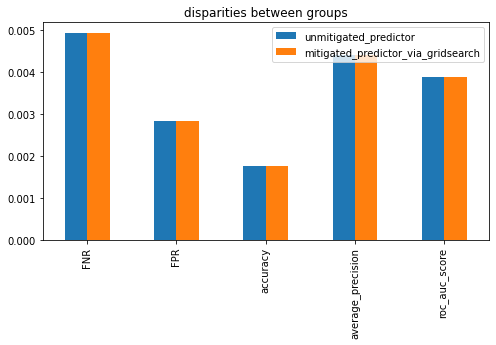

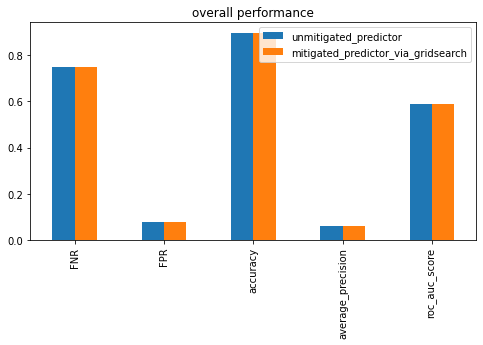

In [ ]:
pd.DataFrame(disparities, index=modelnames).T.plot.bar(figsize=(8, 4), 
                                                       title='disparities between groups')
pd.DataFrame(accuracies, index=modelnames).T.plot.bar(figsize=(8, 4), 
                                                       title='overall performance')

How does the best model selected by GridSearch (the "mitigated_predictor") compare to the unmitigated predictor in terms of disparities between groups and overall performance?



**Write your answer in this text cell:**

It apprears to be exactly the same, but just slightly boosted in accuracy and AUC.

We can also inspect all trained models within GridSearch:



In [ ]:
#get performance for the mitigated predictors from GridSearch
for i, predictor in enumerate(sweep.predictors_):
    accuracy_metric_frame = MetricFrame(metric_fns, 
                                        y_test, predictor.predict(X_test_), 
                                        sensitive_features=A_test['gender'])
    
    accuracies.append(accuracy_metric_frame.overall)
    disparities.append(accuracy_metric_frame.ratio(method='to_overall'))
    modelnames.append(f"grid_{i}")

disparities = pd.DataFrame(disparities, index=modelnames)
accuracies = pd.DataFrame(accuracies, index=modelnames)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f943f73af10>,
      dtype=object)

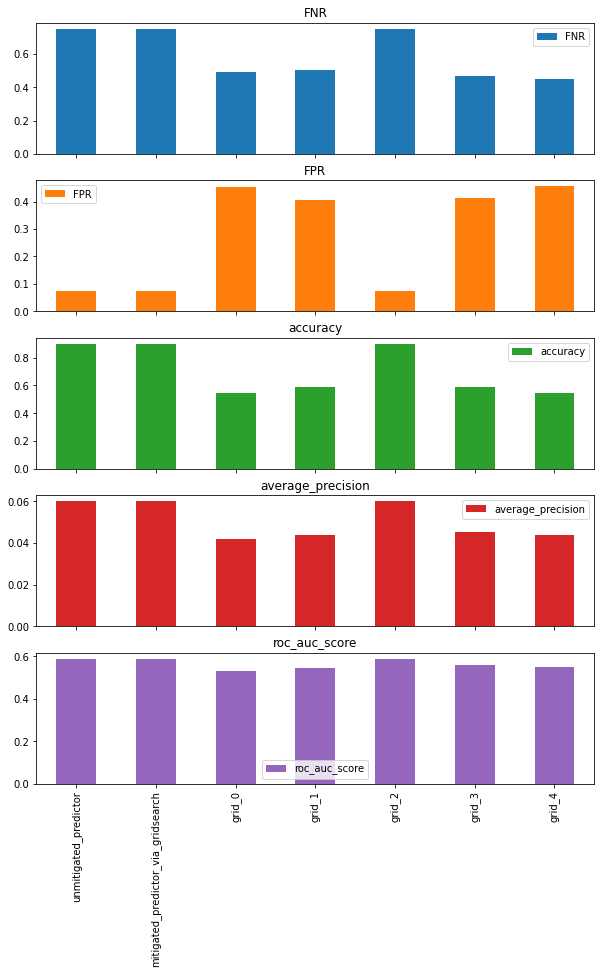

In [ ]:
# We can compare mitigated models' overall performance to the baseline model with above introduce metrics.    
accuracies.plot.bar(subplots=True, figsize=(10, 14))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f943f7876d0>,
      dtype=object)

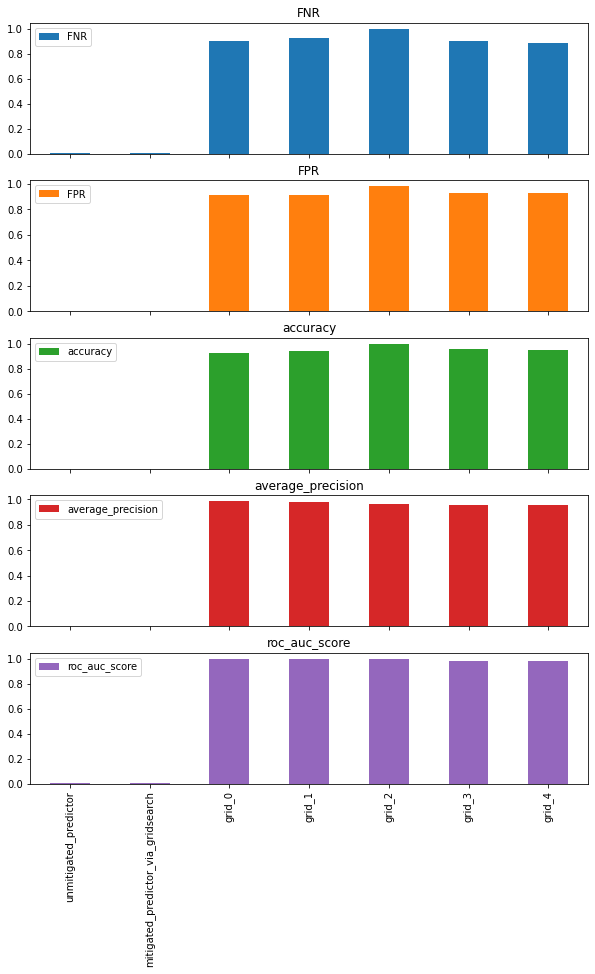

In [ ]:
disparities.plot.bar(subplots=True, figsize=(10, 14))

### Mitigating Difference with Postprocessing

We attempt to mitigate the disparities in the classifier using the Fairlearn postprocessing algorithm **ThresholdOptimizer**. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the model by optimizing the accuracy rate under the constraint that the equalized odds (with respect to the sensitive feature and the outcome) is zero, using the training data. Here we consider race as the sensitive feature.

In [ ]:
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_predictor.named_steps['classifier'],
    constraints="false_negative_rate_parity",
    objective='balanced_accuracy_score'
    )

In [ ]:
postprocess_est.fit(X_train_.toarray(), y_train, 
                    sensitive_features=A_train['race'])

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=LogisticRegression(C=0.1,
                                                class_weight={0: 1, 1: 10},
                                                max_iter=1000),
                   objective='balanced_accuracy_score')

In [ ]:
postprocess_preds = postprocess_est.predict(X_test_.toarray(),
                                            sensitive_features=A_test['race'])

Fairlearn provides the following function,`plot_threshold_optimizer`, to interprete how is the decision maked in `ThresholdOptimizer`. It seeks a threhold for predicted scores that can minimize the disparity estimated by the `constraints` (*false_negative_rate_parity*) and the performance estimated by the `objective`  (*balanced_accuracy_score*). 

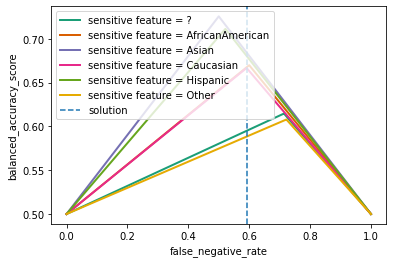

In [ ]:
plot_threshold_optimizer(postprocess_est, ax=None, show_plot=True)

Let's further compare the mitigated and unmitigated models' performance.

In [ ]:
metric_fns = {'FNR': false_negative_rate, 
              'FPR': false_positive_rate, 
              'accuracy': skm.accuracy_score,
              'average_precision': skm.average_precision_score,
              'roc_auc_score': insensitive_roc_auc 
              }

modelnames, accuracies, disparities = [], [], []

#get performance for the unmitigated_predictor 
accuracy_metric_frame = MetricFrame(metric_fns, 
                                    y_test, y_pred, 
                                    sensitive_features=A_test['race'])

accuracies.append(accuracy_metric_frame.overall)
disparities.append(accuracy_metric_frame.ratio(method='to_overall'))
modelnames.append('unmitigated_predictor')

#get performance for the mitigated predictor from GridSearch
accuracy_metric_frame = MetricFrame(metric_fns, 
                                    y_test, postprocess_preds, 
                                    sensitive_features=A_test['race'])

accuracies.append(accuracy_metric_frame.overall)
disparities.append(accuracy_metric_frame.ratio(method='to_overall'))
modelnames.append('mitigated_predictor')


Plot the disparities between groups and overall accuracy metrics for the unmitigated and mitigated predictors below:

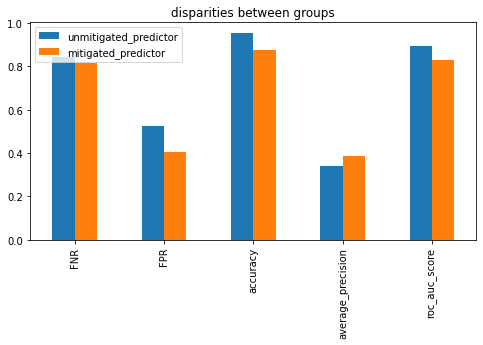

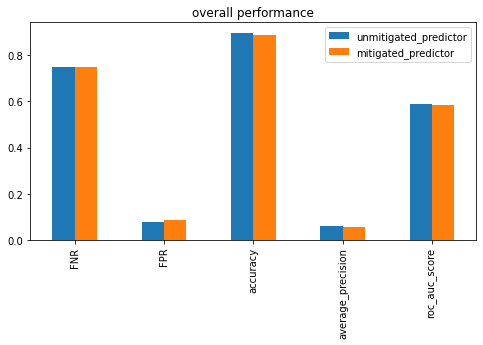

In [ ]:
# write your code here
pd.DataFrame(disparities, index = modelnames).T.plot.bar(figsize =(8,4),
                                                        title = 'disparities between groups')
pd.DataFrame(accuracies, index = modelnames).T.plot.bar(figsize =(8,4),
                                                        title = 'overall performance')

In [ ]:
accuracy_metric_frame.by_group

,FNR,FPR,accuracy,average_precision,roc_auc_score
race,,,,,
?,0.826087,0.20479,0.778555,0.0261197,0.484561
AfricanAmerican,0.714286,0.0725806,0.909804,0.0481793,0.606567
Asian,0.916667,0.0366972,0.917391,0.0570853,0.523318
Caucasian,0.751991,0.0811227,0.889925,0.0625062,0.583443
Hispanic,0.666667,0.0682226,0.90411,0.0946517,0.632555
Other,0.666667,0.209644,0.781893,0.0220544,0.561845


In [ ]:
accuracy_metric_frame = MetricFrame(metric_fns, 
                                    y_test, y_pred, 
                                    sensitive_features=A_test['race'])
accuracy_metric_frame.by_group

,FNR,FPR,accuracy,average_precision,roc_auc_score
race,,,,,
?,0.826087,0.039521,0.939394,0.0409459,0.567196
AfricanAmerican,0.714286,0.0600594,0.921981,0.0534307,0.612827
Asian,0.833333,0.0458716,0.913043,0.071256,0.560398
Caucasian,0.751991,0.0810714,0.889974,0.0625229,0.583469
Hispanic,0.666667,0.0843806,0.888699,0.0843933,0.624476
Other,0.888889,0.0587002,0.925926,0.0202923,0.526205


How do the unmitigated and mitigated predictors compare?

**Write your answer in this text cell:**

The mitigated predictor appears to be slightly more accurate than the unmitigated one, but the precision also falls.

Submit this lab notebook by **5pm ET on Friday 5 
March**.